In [1]:
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')))
#import os; os.chdir(os.path.dirname(os.getcwd()))
from utils.model_loader import get_model_fits
import numpy as np
import pandas as pd
import re
#from sklearn.metrics import mean_squared_errosr
import seaborn as sns
import matplotlib.pyplot as plt

/Users/augustarnstad/Documents/source_code/prior_paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
results_dir_priors = "results/priors/single_layer/tanh/friedman"
results_dir_posteriors = "results/regression/single_layer/tanh/friedman"

prior_names = ["Dirichlet Horseshoe", "Regularized Horseshoe", "Dirichlet Student T", "Gaussian"]
posterior_names = ["Dirichlet Horseshoe tanh", "Regularized Horseshoe tanh", "Dirichlet Student T tanh", "Gaussian tanh"]


prior_N100_fits = get_model_fits(
    config="Friedman_N100_p10_sigma1.00_seed1",
    results_dir=results_dir_priors,
    models=prior_names,
    include_prior=False,
)

prior_N200_fits = get_model_fits(
    config="Friedman_N200_p10_sigma1.00_seed2",
    results_dir=results_dir_priors,
    models=prior_names,
    include_prior=False,
)

prior_N500_fits = get_model_fits(
    config="Friedman_N500_p10_sigma1.00_seed11",
    results_dir=results_dir_priors,
    models=prior_names,
    include_prior=False,
)
    
posterior_N100_fits = get_model_fits(
    config="Friedman_N100_p10_sigma1.00_seed1",
    results_dir=results_dir_posteriors,
    models=posterior_names,
    include_prior=False,
)

posterior_N200_fits = get_model_fits(
    config="Friedman_N200_p10_sigma1.00_seed2",
    results_dir=results_dir_posteriors,
    models=posterior_names,
    include_prior=False,
)

posterior_N500_fits = get_model_fits(
    config="Friedman_N500_p10_sigma1.00_seed11",
    results_dir=results_dir_posteriors,
    models=posterior_names,
    include_prior=False,
)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import hyper
from mpmath import gamma
from scipy.special import poch


p=10
alpha=1
beta=(p-1)*alpha


def p_kappa_dirichlet_horseshoe(kappa, alpha, beta, a_j=1.0):
    if kappa <= 0 or kappa >= 1:
        return 0.0
    prefactor = (1/np.pi) * (a_j / ((1-kappa) * np.sqrt(kappa) * np.sqrt(1-kappa)))# * (1/p)
    c = (-kappa / (1-kappa))*(a_j**2)
    # {}_3F_2([1, 1.1/2, 2.1/1], [1, 3/2], z)
    gamma_const = (gamma(alpha+1/2)/gamma(alpha))*(gamma(alpha+beta)/(gamma(alpha+beta+1/2)))
    hyper_val = hyper([1, alpha+1/2], [alpha+beta+1/2], c)
    return float(prefactor * gamma_const * hyper_val)


def p_kappa_dirichlet_student_t(kappa, alpha, beta, nu=3.0, a_j=1.0):
    if kappa <= 0 or kappa >= 1:
        return 0.0
    C = gamma((nu+1)/2) * 1/(np.sqrt(np.pi * nu) * gamma(nu/2))
    prefactor = ((a_j**nu) * nu**((nu+1)/2) * kappa**(nu/2 - 1)) / ((1-kappa)**(nu/2 + 1)) # * poch(alpha, nu) / poch(p*alpha, nu)
    c = (-kappa / (1-kappa))*(nu * a_j**2)
    gamma_const = (gamma(alpha+nu/2)/gamma(alpha))*(gamma(alpha+beta)/(gamma(alpha+beta+nu/2)))
    hyper_val = hyper([(nu+1)/2, alpha + nu/2], [alpha+beta+nu/2], c)
    return float(C * prefactor * gamma_const * hyper_val)



def p_kappa_horseshoe(kappa, a_j=1.0):
    if kappa <= 0 or kappa >= 1:
        return 0.0
    prefactor = (1/np.pi) * (a_j / ((a_j**2-1)*kappa + 1)) * 1/(np.sqrt(kappa) * np.sqrt(1-kappa))
    return float(prefactor)


Dirichlet Horseshoe: 

$\frac{1}{\pi} \cdot \frac{a_j}{(1-\kappa) \cdot \sqrt{\kappa} \cdot \sqrt{1-\kappa}}$ 

$c = -\frac{\kappa}{(1-\kappa)} \cdot a_j^2$

$\frac{\Gamma(\alpha + \nu/2)}{\Gamma(\alpha)}  \cdot \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha + \beta + \nu/2)}$ 

${}_2F_1\left(\frac{\nu+1}{2}, \alpha + \nu/2; \alpha + \beta + \nu/2;  c\right)$ 

$p(\kappa) = \frac{1}{\pi} \cdot \frac{a_j}{(1-\kappa) \cdot \sqrt{\kappa} \cdot \sqrt{1-\kappa}} \frac{\Gamma(\alpha + \nu/2)}{\Gamma(\alpha)}  \cdot \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha + \beta + \nu/2)}{}_2F_1\left(\frac{\nu+1}{2}, \alpha + \nu/2; \alpha + \beta + \nu/2;  c\right)$

Dirichlet Student T:

$\Gamma(\frac{\nu + 1}{2}) \frac{1}{\sqrt{\pi \nu} \Gamma(\nu/2)}$

$\frac{a_j^{\nu} \nu^{\frac{\nu + 1}{2}} \kappa^{\frac{\nu}{2} - 1}}{(1-\kappa)^{\frac{\nu}{2} + 1}}$


$ c= - \frac{\kappa}{(1-\kappa)} \cdot a_j^2$


$\frac{\Gamma(\alpha + \nu/2)}{\Gamma(\alpha)} \cdot \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha + \beta + \nu/2)}$


${}_2F_1\left( \frac{\nu+1}{2}, \alpha + \nu/2; \alpha + \beta + \nu/2; c \right)$

$p(\kappa) = \Gamma(\frac{\nu + 1}{2}) \frac{1}{\sqrt{\pi \nu} \Gamma(\nu/2)}\frac{\Gamma(\alpha + \nu/2)}{\Gamma(\alpha)} \cdot \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha + \beta + \nu/2)} \frac{a_j^{\nu} \nu^{\frac{\nu + 1}{2}} \kappa^{\frac{\nu}{2} - 1}}{(1-\kappa)^{\frac{\nu}{2} + 1}} {}_2F_q\left( \frac{\nu+1}{2}, \alpha + \nu/2; \alpha + \beta + \nu/2; c \right)$

I have updated the density plot!

\begin{equation}
\begin{aligned}
    \frac{1}{\pi} \frac{\sqrt{q_{j}} \tau}{(1-\kappa_j)\sqrt{\kappa_j}\sqrt{1-\kappa_j}} \frac{\Gamma(\alpha+\frac{1}{2})}{\Gamma(\alpha)}\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha+\beta+\frac{1}{2})}{}_2F_1\!\left(\begin{matrix} 1, \alpha+\frac{1}{2} \\ \alpha + \beta + \frac{1}{2} \end{matrix}; -c \right)
\end{aligned} 
\end{equation}

\begin{equation}
\begin{aligned}
\frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu\pi}\Gamma(\frac{\nu}{2})}  \frac{1}{(1-\kappa)^{\frac{\nu}{2}+1}}\nu^{\frac{\nu + 1}{2}} \kappa^{\frac{\nu}{2}-1}q_{j}^{\frac{\nu}{2}}\tau^{\nu} \mathbb{E}_{\xi_j}\left[\frac{\xi_j^{\nu/2}}{\left(1+c\xi_j\right)^{\frac{\nu+1}{2}}}\right]
\end{aligned} 
\end{equation}

In [3]:
# Lag kappa-grid
kappa_vals = np.linspace(0.001, 0.999, 500)
p_vals_dirichlet_horseshoe = [p_kappa_dirichlet_horseshoe(k, alpha, beta) for k in kappa_vals]
p_vals_dirichlet_horseshoe_medium_low = [p_kappa_dirichlet_horseshoe(k, alpha, beta, a_j=0.7) for k in kappa_vals]
p_vals_dirichlet_horseshoe_medium_high = [p_kappa_dirichlet_horseshoe(k, alpha, beta, a_j=2) for k in kappa_vals]
p_vals_dirichlet_horseshoe_low = [p_kappa_dirichlet_horseshoe(k, alpha, beta, a_j=0.1) for k in kappa_vals]
p_vals_dirichlet_horseshoe_high = [p_kappa_dirichlet_horseshoe(k, alpha, beta, a_j=5) for k in kappa_vals]

p_vals_dirichlet_student_t = [p_kappa_dirichlet_student_t(k, alpha, beta) for k in kappa_vals]
p_vals_dirichlet_student_t_medium_low = [p_kappa_dirichlet_student_t(k, alpha, beta, a_j=0.7) for k in kappa_vals]
p_vals_dirichlet_student_t_medium_high = [p_kappa_dirichlet_student_t(k, alpha, beta, a_j=2) for k in kappa_vals]
p_vals_dirichlet_student_t_low = [p_kappa_dirichlet_student_t(k, alpha, beta, a_j=0.1) for k in kappa_vals]
p_vals_dirichlet_student_t_high = [p_kappa_dirichlet_student_t(k, alpha, beta, a_j=5) for k in kappa_vals]

p_vals_horseshoe = [p_kappa_horseshoe(k) for k in kappa_vals]
p_vals_horseshoe_medium_low = [p_kappa_horseshoe(k, a_j=0.7) for k in kappa_vals]
p_vals_horseshoe_medium_high = [p_kappa_horseshoe(k, a_j=2) for k in kappa_vals]
p_vals_horseshoe_low = [p_kappa_horseshoe(k, a_j=0.1) for k in kappa_vals]
p_vals_horseshoe_high = [p_kappa_horseshoe(k, a_j=5) for k in kappa_vals]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


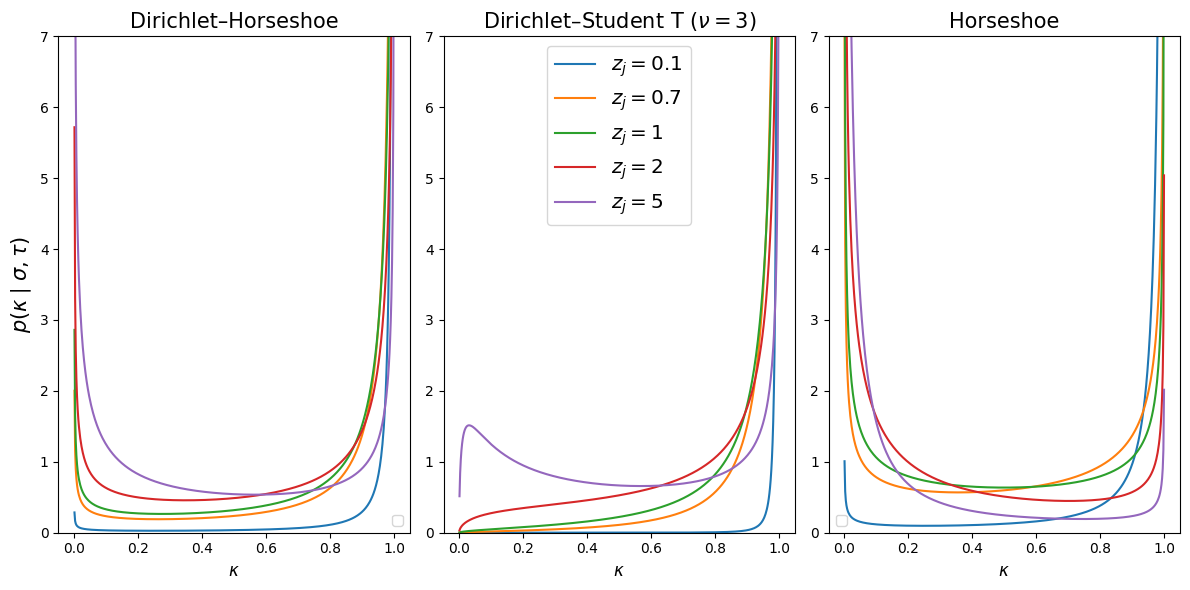

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=False)

axes[0].plot(kappa_vals, p_vals_dirichlet_horseshoe_low)#, label=r"$a_j = 0.1$")
axes[0].plot(kappa_vals, p_vals_dirichlet_horseshoe_medium_low)#, label=r"$a_j = 0.7$")
axes[0].plot(kappa_vals, p_vals_dirichlet_horseshoe)#, label=r"$a_j = 1$")
axes[0].plot(kappa_vals, p_vals_dirichlet_horseshoe_medium_high)#, label=r"$a_j = 2$")
axes[0].plot(kappa_vals, p_vals_dirichlet_horseshoe_high)#, label=r"$a_j = 5$")
axes[0].set_ylabel(r"$p(\kappa \mid \sigma, \tau)$", fontsize=15)
axes[0].set_xlabel(r"$\kappa$", fontsize=12)
axes[0].set_title("Dirichlet–Horseshoe", fontsize=15)
axes[0].set_ylim((0, 7))
axes[0].legend()

axes[1].plot(kappa_vals, p_vals_dirichlet_student_t_low, label=r"$z_j = 0.1$")
axes[1].plot(kappa_vals, p_vals_dirichlet_student_t_medium_low, label=r"$z_j = 0.7$")
axes[1].plot(kappa_vals, p_vals_dirichlet_student_t, label=r"$z_j = 1$")
axes[1].plot(kappa_vals, p_vals_dirichlet_student_t_medium_high, label=r"$z_j = 2$")
axes[1].plot(kappa_vals, p_vals_dirichlet_student_t_high, label=r"$z_j = 5$")
#axes[1].set_ylabel(r"$p(\kappa \mid \sigma, \tau)$")
axes[1].set_xlabel(r"$\kappa$", fontsize=12)
axes[1].set_title(r"Dirichlet–Student T $(\nu=3)$", fontsize=15)
axes[1].set_ylim((0, 7))
axes[1].legend(loc='upper center', fontsize='x-large')

axes[2].plot(kappa_vals, p_vals_horseshoe_low)#, label=r"$a_j = 0.1$")
axes[2].plot(kappa_vals, p_vals_horseshoe_medium_low)#, label=r"$a_j = 0.7$")
axes[2].plot(kappa_vals, p_vals_horseshoe)#, label=r"$a_j = 1$")
axes[2].plot(kappa_vals, p_vals_horseshoe_medium_high)#, label=r"$a_j = 2$")
axes[2].plot(kappa_vals, p_vals_horseshoe_high)#, label=r"$a_j = 5$")
#axes[2].set_ylabel(r"$p(\kappa \mid \sigma, \tau)$")
axes[2].set_xlabel(r"$\kappa$", fontsize=12)
axes[2].set_title("Horseshoe", fontsize=15)
axes[2].set_ylim((0, 7))
axes[2].legend()

plt.tight_layout()
plt.savefig("figures_for_use_in_paper/kappa_prior.pdf", bbox_inches="tight")
plt.show()


In [ ]:
kappa_vals = np.linspace(0.001, 0.999, 500)
p_DHS = [p_kappa_dirichlet_horseshoe(k, alpha, beta, a_j=np.sqrt(10)*0.1) for k in kappa_vals]
p_HS = [p_kappa_horseshoe(k, a_j=0.1) for k in kappa_vals]
plt.figure()
plt.plot(kappa_vals, p_DHS, label=r"DHS")
plt.plot(kappa_vals, p_HS, label=r"HS")
plt.xlabel(r"$\kappa$")
plt.title(r"Dirichlet–Student T $(\nu=3)$")
plt.ylim((0, 7))
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet, beta, cauchy, gaussian_kde

def sample_half_cauchy(n_samples, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    # Cauchy(0,1) and take absolute value
    return np.abs(cauchy.rvs(loc=0.0, scale=1.0, size=n_samples, random_state=rng))

def sample_kappa_joint_dirichlet(alpha, p, t_j=1.0, n_samples=50_000, rng=None):
    """
    DSM prior:
      xi ~ Dir(alpha, ..., alpha)
      lambda_j ~ half-Cauchy iid
      kappa_j = 1 / (1 + t_j^2 * lambda_j^2 * xi_j)
    
    Returns
    -------
    kappa : array of shape (n_samples, p)
    """
    if rng is None:
        rng = np.random.default_rng()

    # Dirichlet for all p coordinates
    xi = rng.dirichlet([alpha] * p, size=n_samples)  # (n_samples, p)

    # Local scales lambda_j ~ C^+(0,1), independent across j and samples
    lam = sample_half_cauchy(n_samples * p, rng=rng).reshape(n_samples, p)

    kappa = 1.0 / (1.0 + (t_j**2) * lam**2 * xi)
    return kappa, xi


def sample_kappa_indep_beta(alpha, p, t_j=1.0, n_samples=50_000, rng=None):
    """
    Fake prior:
      xi_j ~ Beta(alpha, (p-1)*alpha) independently across j
      lambda_j ~ half-Cauchy iid
      kappa_j = 1 / (1 + t_j^2 * lambda_j^2 * xi_j)
    
    Returns
    -------
    kappa : array of shape (n_samples, p)
    """
    if rng is None:
        rng = np.random.default_rng()

    a = alpha
    b = (p - 1) * alpha

    # Xi_j iid Beta
    xi = beta.rvs(a, b, size=(n_samples, p), random_state=rng)
    # Local scales
    lam = sample_half_cauchy(n_samples * p, rng=rng).reshape(n_samples, p)

    kappa = 1.0 / (1.0 + (t_j**2) * lam**2 * xi)
    return kappa



In [ ]:
alpha = 0.1
p = 10
t_j = 1.0
n_samples = 200_000
rng = np.random.default_rng(123)

kappa_dir, xi = sample_kappa_joint_dirichlet(alpha, p, t_j, n_samples, rng)
kappa_beta = sample_kappa_indep_beta(alpha, p, t_j, n_samples, rng)

# Pick one coordinate, say j = 0
j = 0
kd = kappa_dir[:, j]
kb = kappa_beta[:, j]

# Estimate densities by KDE
def kde_on_unit_interval(samples, grid=None, bw_factor=0.3):
    samples = np.asarray(samples)
    samples = samples[(samples > 0) & (samples < 1)]
    if grid is None:
        grid = np.linspace(1e-4, 1 - 1e-4, 400)
    kde = gaussian_kde(samples)
    kde.set_bandwidth(bw_method=kde.factor * bw_factor)
    return grid, kde(grid)

grid, dens_dir = kde_on_unit_interval(kd)
_, dens_beta = kde_on_unit_interval(kb, grid=grid)

plt.figure(figsize=(6,4))
plt.plot(grid, dens_dir, label="Dirichlet prior (true DSM)", lw=2)
plt.plot(grid, dens_beta, "--", label="Independent Beta approx", lw=2)
plt.xlabel(r"$\kappa_j$")
plt.ylabel(r"$p(\kappa_j)$")
plt.legend()
plt.title("Marginal prior of one shrinkage factor")
plt.tight_layout()
plt.show()


In [ ]:
corr_xi = np.corrcoef(xi, rowvar=False)
corr_xi

In [ ]:
# Compute correlation matrices
corr_dir = np.corrcoef(kappa_dir, rowvar=False)  # (p, p)
corr_beta = np.corrcoef(kappa_beta, rowvar=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(corr_dir, vmin=-1, vmax=1, cmap="coolwarm")
axes[0].set_title("Corr($\\kappa$) under Dirichlet DSM")
axes[0].set_xticks(range(p))
axes[0].set_yticks(range(p))

im1 = axes[1].imshow(corr_beta, vmin=-1, vmax=1, cmap="coolwarm")
axes[1].set_title("Corr($\\kappa$) under independent Beta")
axes[1].set_xticks(range(p))
axes[1].set_yticks(range(p))

fig.colorbar(im0, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()


In [ ]:
m_eff_dir  = np.sum(1.0 - kappa_dir,  axis=1)
m_eff_beta = np.sum(1.0 - kappa_beta, axis=1)

plt.figure(figsize=(6,4))
plt.hist(m_eff_dir, bins=60, density=True, alpha=0.6, label="Dirichlet DSM")
plt.hist(m_eff_beta, bins=60, density=True, alpha=0.6, label="Independent Beta")
plt.xlabel(r"$m_{\mathrm{eff}} = \sum_j (1-\kappa_j)$")
plt.ylabel("density")
plt.legend()
plt.title("Prior over effective model size")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np, mpmath as mp

def theory_beta(alpha, beta, s):
    t1 = mp.hyp2f1(1, alpha, alpha + beta, -s)
    return t1

def empirical_estimate(alpha, beta, s, n=100_000, seed=123):
    rng = np.random.default_rng(seed)
    xi = rng.beta(alpha, beta, size=n)
    vals = 1.0 / (1.0 + s * xi)
    m = float(vals.mean())
    se = float(vals.std(ddof=1) / np.sqrt(n))
    return m, se

# --- set parameters ---
p=10
alpha, beta = 0.1, (p-1)*alpha
s, n, seed  = 5.0, 1_000_000, 123  # require s > -1
# ----------------------

theory = float(theory_beta(alpha, beta, s))
emp, se = empirical_estimate(alpha, beta, s, n, seed)
diff, z = emp - theory, (emp - theory) / se


print("theory", np.round(theory, 5), "\nempirical", np.round(emp, 5), "\nabs_diff", np.round(diff, 5), "\nSE_MC", np.round(se, 5), "\nz_score", np.round(z, 5))



I den følgende koden, for s=1, får vi NAN fordi det er en pol her. Det kan være at vi også får en imaginærdel, selv om jeg tror den egentlig kanselleres. Den er generelt veldig liten.

In [ ]:
import numpy as np, mpmath as mp
from mpmath import hyper
from mpmath import gamma

def poch(x, n):  # rising factorial (x)_n for real n
    return gamma(x + n) / gamma(x)

def theory_beta_sqrt(alpha, beta, s):
    t1 = hyper([1, alpha], [alpha + beta], s**2)
    t2 = s * poch(alpha, 0.5) / poch(alpha + beta, 0.5) * hyper([1, alpha + 0.5], [alpha + beta + 0.5], s**2)
    return t1 - t2

def empirical_estimate(alpha, beta, s, n=100_000, seed=123):
    rng = np.random.default_rng(seed)
    xi = rng.beta(alpha, beta, size=n)
    vals = 1.0 / (1.0 + s * np.sqrt(xi))
    m = float(vals.mean())
    se = float(vals.std(ddof=1) / np.sqrt(n))
    return m, se

# --- set parameters ---
p=10
alpha = 0.1
beta = (p-1)*alpha
s, n, seed  = 3.0, 1_000_000, 123  # require s > -1
# ----------------------
print(np.imag(theory_beta_sqrt(alpha, beta, s)))
theory = float(np.real(theory_beta_sqrt(alpha, beta, s)))
emp, se = empirical_estimate(alpha, beta, s, n, seed)
diff, z = emp - theory, (emp - theory) / se


print("theory", np.round(theory, 5), "\nempirical", np.round(emp, 5), "\nabs_diff", np.round(diff, 5), "\nSE_MC", np.round(se, 5), "\nz_score", np.round(z, 5))



In [ ]:
import mpmath as mp
mp.dps = 80

def theory_via_quad(alpha, beta, s):
    B = mp.beta(alpha, beta)
    f = lambda t: 2 * (t**(2*alpha-1)) * ((1 - t*t)**(beta-1)) / (1 + s*t)
    return mp.quad(f, [0, 1]) / B

def empirical_estimate(alpha, beta, s, n=100_000, seed=123):
    rng = np.random.default_rng(seed)
    xi = rng.beta(alpha, beta, size=n)
    vals = 1.0 / (1.0 + s * np.sqrt(xi))
    m = float(vals.mean())
    se = float(vals.std(ddof=1) / np.sqrt(n))
    return m, se

# --- set parameters ---
p=10
alpha, beta = 0.1, (p-1)*alpha
s, n, seed  = 5.0, 1_000_000, 123  # require s > -1
# ----------------------
theory = float(theory_via_quad(alpha, beta, s))
emp, se = empirical_estimate(alpha, beta, s, n, seed)
diff, z = emp - theory, (emp - theory) / se


print("theory", np.round(theory, 5), "\nempirical", np.round(emp, 5), "\nabs_diff", np.round(diff, 5), "\nSE_MC", np.round(se, 5), "\nz_score", np.round(z, 5))



## SAMPLES

In [7]:
path = "datasets/friedman/Friedman_N500_p10_sigma1.00_seed11.npz"
data = np.load(path)


In [16]:
import numpy as np

# ---------- 1) Simuler X ----------
def simulate_X(n, P, seed=42):
    rng = np.random.default_rng(seed)
    return rng.uniform(0.0, 1.0, size=(n, P))

# ---------- 2) Aktivering og derivert ----------
def get_activation(activation="tanh"):
    if activation == "tanh":
        phi = np.tanh
        def dphi(a): return 1.0 - np.tanh(a)**2
    elif activation == "relu":
        def phi(a): return np.maximum(0.0, a)
        def dphi(a): return (a > 0.0).astype(a.dtype)
    else:
        raise ValueError(f"Unsupported activation: {activation}")
    return phi, dphi

# ---------- 3) Hovedfunksjon: q for alle trekk ----------
def compute_q_for_fit(cmdstan_mcmc, N=1000, activation="tanh", seed=1, output_index=0, X=None):
    """
    Beregn q_{ell, j} for første-lagsvektene for hver trekk (draw).
    Returnerer:
      q_draws:  (n_draws, H, P)
      q_mean:   (H, P)  – gjennomsnitt over trekk
      X:        (N, P)  – datasettet brukt i beregningen
    """
    # Hent ut variabler fra Stan
    W1_all = cmdstan_mcmc.stan_variable("W_1")            # (draws, P, H)
    WL_all = cmdstan_mcmc.stan_variable("W_L")             # (draws, H, O)
    hb_all = cmdstan_mcmc.stan_variable("hidden_bias")     # (draws, L, H)
    sigma_all = cmdstan_mcmc.stan_variable("sigma")        # (draws,)
    Wint_all = cmdstan_mcmc.stan_variable("W_internal")    # (draws, max(L-1,1), H, H)

    draws, P, H = W1_all.shape
    O = WL_all.shape[2]
    L = hb_all.shape[1]

    if O == 0:
        raise ValueError("W_L has zero output nodes. Expected at least 1.")
    if output_index < 0 or output_index >= O:
        raise ValueError(f"output_index {output_index} out of range 0..{O-1}")

    if X is None:
        X = simulate_X(N, P, seed=seed)

    X_sq = X**2
    phi, dphi = get_activation(activation)

    q_draws = np.empty((draws, H, P), dtype=float)

    for s in range(draws):
        W1 = W1_all[s]            # (P, H)
        WL = WL_all[s]            # (H, O)
        hb = hb_all[s]            # (L, H)
        Wints = Wint_all[s]       # (max(L-1,1), H, H)
        sigma = float(sigma_all[s])

        # ----- Forward pass -----
        a_list = []
        h_list = []

        a = X @ W1 + hb[0]        # (N, H)
        h = phi(a)
        a_list.append(a); h_list.append(h)

        for l in range(1, L):
            Wl = Wints[l-1]       # (H, H)
            a = h @ Wl + hb[l]    # (N, H)
            h = phi(a)
            a_list.append(a); h_list.append(h)

        # ----- Backward: delta_L = d f / d a^(L) -----
        # lineær utgang: df/dh^(L) = WL[:, output_index]
        v = WL[:, output_index]           # (H,)
        delta = dphi(a_list[-1]) * v      # (N, H), broadcast over N

        # Bakover gjennom skjulte lag
        for l in range(L-2, -1, -1):
            Wnext = Wints[l]              # (H, H) – brukes bare hvis L>1
            delta = (delta @ Wnext.T) * dphi(a_list[l]) if L > 1 else delta

        delta1 = delta  # (N, H) == ∂f/∂a^(1)

        # ----- q: (1/sigma^2) * sum_i (delta1[i,ell]^2 * X[i,j]^2) -----
        D_sq = delta1**2                  # (N, H)
        Q = (X_sq.T @ D_sq) / (sigma**2)  # (P, H)
        q_draws[s] = Q.T                  # (H, P)

    q_mean = q_draws.mean(axis=0)         # (H, P)
    return q_draws, q_mean, X

# ---------- 4) Eksempelbruk ----------
# Velg riktig fit-objekt (CmdStanMCMC) fra dict-en din:
prior_q_dhs, prior_q_mean_dhs, X_train = compute_q_for_fit(
    prior_N500_fits['Dirichlet Horseshoe']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

posterior_q_dhs, posterior_q_mean_dhs, X_train = compute_q_for_fit(
    posterior_N500_fits['Dirichlet Horseshoe tanh']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

prior_q_dst, prior_q_mean_dst, X_train = compute_q_for_fit(
    prior_N500_fits['Dirichlet Student T']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

posterior_q_dst, posterior_q_mean_dst, X_train = compute_q_for_fit(
    posterior_N500_fits['Dirichlet Student T tanh']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

prior_q_rhs, prior_q_mean_rhs, X_train = compute_q_for_fit(
    prior_N500_fits['Regularized Horseshoe']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

posterior_q_rhs, posterior_q_mean_rhs, X_train = compute_q_for_fit(
    posterior_N500_fits['Regularized Horseshoe tanh']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

prior_q_gauss, prior_q_mean_gauss, X_train = compute_q_for_fit(
    prior_N500_fits['Gaussian']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

posterior_q_gauss, posterior_q_mean_gauss, X_train = compute_q_for_fit(
    posterior_N500_fits['Gaussian tanh']['posterior'],
    N=1000,             
    activation='tanh',  
    seed=123,
    output_index=0,
    X = data["X_train"]      
)

# prior_q_gamma, prior_q_mean_gamma, X_train = compute_q_for_fit(
#     prior_fits['Dirichlet Gamma']['posterior'],
#     N=1000,             
#     activation='tanh',  
#     seed=123,
#     output_index=0,
#     X = data["X_train"]      
# )

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- choose which node/input to inspect ----
node_idx = 1
input_idx = 1

## Dirichlet Horseshoe

In [6]:
# -------- PRIOR --------
prior_fit = prior_fits['Dirichlet Horseshoe']['posterior']
tau_prior = prior_fit.stan_variable("tau")                                   # (draws_prior,)
lam_prior = prior_fit.stan_variable("lambda_tilde_data")[:, :, node_idx][:, input_idx]  # (draws_prior,)
phi_prior = prior_fit.stan_variable("phi_data")[:, :, node_idx][:, input_idx]           # (draws_prior,)
q_prior   = prior_q_dhs[:, node_idx, input_idx]                               # (draws_prior,)

# -------- POSTERIOR --------
post_fit = posterior_N100_fits['Dirichlet Horseshoe tanh']['posterior']
tau_post = post_fit.stan_variable("tau")                                      # (draws_post,)
lam_post = post_fit.stan_variable("lambda_tilde_data")[:, :, node_idx][:, input_idx]    # (draws_post,)
phi_post = post_fit.stan_variable("phi_data")[:, :, node_idx][:, input_idx]             # (draws_post,)
q_post   = posterior_q_dhs[:, node_idx, input_idx]                           # (draws_post,)

kappa_DHS_prior = 1.0 / (1.0 + q_prior * (tau_prior**2) * (lam_prior**2) * (phi_prior**2))
kappa_DHS_post = 1.0 / (1.0 + q_post * (tau_post**2) * (lam_post**2) * (phi_post**2))

## Dirichlet Student T

In [7]:
# -------- PRIOR --------
prior_fit = prior_fits['Dirichlet Student T']['posterior']
tau_prior = prior_fit.stan_variable("tau")                                   # (draws_prior,)
lam_prior = prior_fit.stan_variable("lambda_tilde_data")[:, :, node_idx][:, input_idx]  # (draws_prior,)
phi_prior = prior_fit.stan_variable("phi_data")[:, :, node_idx][:, input_idx]           # (draws_prior,)
q_prior   = prior_q_dhs[:, node_idx, input_idx]                               # (draws_prior,)

# -------- POSTERIOR --------
post_fit = posterior_N100_fits['Dirichlet Student T tanh']['posterior']
tau_post = post_fit.stan_variable("tau")                                      # (draws_post,)
lam_post = post_fit.stan_variable("lambda_tilde_data")[:, :, node_idx][:, input_idx]    # (draws_post,)
phi_post = post_fit.stan_variable("phi_data")[:, :, node_idx][:, input_idx]             # (draws_post,)
q_post   = posterior_q_dhs[:, node_idx, input_idx]                           # (draws_post,)


kappa_DST_prior = 1.0 / (1.0 + q_prior * (tau_prior**2) * (lam_prior**2) * (phi_prior**2))
kappa_DST_post = 1.0 / (1.0 + q_post * (tau_post**2) * (lam_post**2) * (phi_post**2))

## Dirichlet Gamma

In [8]:
# -------- PRIOR --------
prior_fit = prior_fits['Dirichlet Gamma']['posterior']
tau_prior = prior_fit.stan_variable("tau")                                   # (draws_prior,)
lam_prior = prior_fit.stan_variable("lambda_data")[:, :, node_idx][:, input_idx]  # (draws_prior,)
phi_prior = prior_fit.stan_variable("phi_data")[:, :, node_idx][:, input_idx]           # (draws_prior,)
q_prior   = prior_q_gamma[:, node_idx, input_idx]                               # (draws_prior,)


kappa_DG_prior = 1.0 / (1.0 + q_prior * (tau_prior**2) * (lam_prior**2) * (phi_prior**2))

## Regularized Horseshoe

In [9]:
prior_fit = prior_fits['Regularized Horseshoe']['posterior']
tau_prior = prior_fit.stan_variable("tau")                                   # (draws_prior,)
lam_prior = prior_fit.stan_variable("lambda_tilde")[:, :, node_idx][:, input_idx]  # (draws_prior,)
q_prior   = prior_q_rhs[:, node_idx, input_idx]                               # (draws_prior,)

post_rhs_fit = posterior_N100_fits['Regularized Horseshoe tanh']['posterior']
tau_rhs_post = post_rhs_fit.stan_variable("tau")                                      # (draws_post,)
lam_rhs_post = post_rhs_fit.stan_variable("lambda_tilde")[:, :, node_idx][:, input_idx]    # (draws_post,)
q_rhs_post   = posterior_q_rhs[:, node_idx, input_idx]                           # (draws_post,)

kappa_HS_prior = 1.0 / (1.0 + q_prior * (tau_prior**2) * (lam_prior**2))
kappa_HS_post = 1.0 / (1.0 + q_rhs_post * (tau_rhs_post**2) * (lam_rhs_post**2))

## Gaussian

In [10]:
q_prior   = prior_q_gauss[:, node_idx, input_idx]                               # (draws_prior,)

q_gauss_post   = posterior_q_gauss[:, node_idx, input_idx]                           # (draws_post,)

kappa_gauss_prior = 1.0 / (1.0 + q_prior)
kappa_gauss_post = 1.0 / (1.0 + q_gauss_post)

In [ ]:
# -------- Plot: prior vs posterior overlays --------
bins = np.linspace(0.0, 1.0, 40)  # common bins so densities are comparable

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)


# Horseshoe
axes[0, 0].hist(kappa_gauss_prior, bins=bins, density=True, alpha=0.45, label="Prior")
axes[0, 0].hist(kappa_gauss_post,  bins=bins, density=True, alpha=0.45, label="Posterior")
axes[0, 0].set_title("Gaussian")
axes[0, 0].set_xlabel(r"$\kappa_{\ell j}$")
axes[0, 0].legend()

# Horseshoe
axes[0, 1].hist(kappa_HS_prior, bins=bins, density=True, alpha=0.45, label="Prior")
axes[0, 1].hist(kappa_HS_post,  bins=bins, density=True, alpha=0.45, label="Posterior")
axes[0, 1].set_title("RHS")
axes[0, 1].set_xlabel(r"$\kappa_{\ell j}$")
axes[0, 1].legend()

# Dirichlet–Horseshoe
axes[1, 0].hist(kappa_DHS_prior, bins=bins, density=True, alpha=0.45, label="Prior")
axes[1, 0].hist(kappa_DHS_post,  bins=bins, density=True, alpha=0.45, label="Posterior")
axes[1, 0].set_title("DHS")
axes[1, 0].set_xlabel(r"$\kappa_{\ell j}$")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()

# Dirichlet–Horseshoe
axes[1, 1].hist(kappa_DST_prior, bins=bins, density=True, alpha=0.45, label="Prior")
axes[1, 1].hist(kappa_DST_post,  bins=bins, density=True, alpha=0.45, label="Posterior")
axes[1, 1].set_title("DS-T")
axes[1, 1].set_xlabel(r"$\kappa_{\ell j}$")
axes[1, 1].legend()


plt.suptitle(f"Node {node_idx}, input {input_idx}")#: Prior vs Posterior")
plt.tight_layout()
plt.show()

In [ ]:
plt.plot()
plt.hist(kappa_DG_prior, bins=50, density=True, alpha=0.45, label="Dirichlet Gamma prior")
plt.legend()
#plt.xlim(3, 50)
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(7,5))

colors = {
    "Gaussian": "C0",
    "RHS": "C1",
    "DHS": "C2",
    "DS-T": "C3",
}

# Plot linjene
sns.kdeplot(kappa_gauss_prior, linestyle="--", color=colors["Gaussian"])
sns.kdeplot(kappa_gauss_post, linestyle="-",  color=colors["Gaussian"])
sns.kdeplot(kappa_HS_prior, linestyle="--", color=colors["RHS"])
sns.kdeplot(kappa_HS_post, linestyle="-",  color=colors["RHS"])
sns.kdeplot(kappa_DHS_prior, linestyle="--", color=colors["DHS"])
sns.kdeplot(kappa_DHS_post, linestyle="-",  color=colors["DHS"])
sns.kdeplot(kappa_DST_prior, linestyle="--", color=colors["DS-T"])
sns.kdeplot(kappa_DST_post, linestyle="-",  color=colors["DS-T"])

plt.xlabel(r"$\kappa_{\ell j}$")
plt.ylabel("Density")
plt.title("Prior shrinkage factors – KDE")

# --- Lag legend ---
# Farger (modeller)
model_handles = [Line2D([0], [0], color=color, lw=2, label=model) 
                 for model, color in colors.items()]

# Linjestil (prior/posterior)
style_handles = [
    Line2D([0], [0], color="black", linestyle="--", lw=2, label="Prior"),
    Line2D([0], [0], color="black", linestyle="-",  lw=2, label="Posterior")
]

# Kombiner
handles = model_handles + style_handles
labels = [h.get_label() for h in handles]

plt.legend(handles=handles, labels=labels, title="Model / Distribution", ncol=1)
plt.show()


## Regularized versions

For the Regularized Horseshoe, when $c<\infty$. the shrinkage profile becomes approximately equivalent to that of the horseshoe shifted from the interval $(0, 1)$ to $(b_{\ell, j}, 1)$ where $b_{\ell, j}=\frac{1}{q_{\ell, j}\tau{\ell}^2c^2}$. The shrinkage factor then approximately satisfies $\tilde{\kappa}_{\ell, j}=(1-b_j)\kappa_{\ell, j} + b_j$ where $\tilde{\kappa}_{\ell, j}$ is the shrinkage factor of the original horseshoe. From this we get $1-\tilde{\kappa}_{\ell, j}=(1-b_j)(1-\kappa_{\ell, j})$. Assuming roughly the same scale of inputs, then $b_{\ell, j}=b_{\ell}$ and the effective model complexity becomes $\tilde{m}_{\ell, eff}=(1-b_{\ell}) m_{\ell, eff}$ where $m_{\ell, eff}=\sum_{j=1}^p(1-\kappa_{\ell, j})$ denotes the effective number of nonzero weights into node $l$ (I THINK)

In [17]:
import numpy as np

def compute_kappa(fit, q, node_idx, input_idx, model_type='gaussian'):
    """
    Returnerer arrays per trekning (S,): kappa_original, b_j, kappa_tilde
    """
    q_hp = np.asarray(q)[:, node_idx, input_idx]  # (S,)

    if model_type == 'gaussian':
        tau = 1.0
        lam = 1.0
        c_sq = 1.0
        phi = 1.0
    else:
        tau = fit.stan_variable("tau")                          # (S,)
        c_sq = fit.stan_variable("c_sq")[:, node_idx]           # (S,)

        if model_type == 'rhs':
            lam = fit.stan_variable("lambda_tilde")[:, node_idx, input_idx]       # (S,)
            phi = 1.0
        elif model_type == 'dhs' or 'dst':
            lam = fit.stan_variable("lambda_tilde_data")[:, node_idx, input_idx]  # (S,)
            phi = fit.stan_variable("phi_data")[:, node_idx, input_idx]           # (S,)
        # elif model_type == 'dst':
        #     lam = fit.stan_variable("lambda_tilde_data")[:, node_idx, input_idx]       # (S,)
        #     phi = fit.stan_variable("phi_data")[:, node_idx, input_idx]           # (S,)
        else:
            raise ValueError("model_type må være 'gaussian', 'rhs', 'dhs' eller 'dst'.")

    kappa_original = 1.0 / (1.0 + q_hp * (tau**2) * (lam**2) * (phi))  # (S,)
    b_j            = 1.0 / (1.0 + q_hp * (tau**2) * c_sq * (phi))      # (S,)
    kappa_tilde    = (1.0 - b_j) * kappa_original + b_j                # (S,)

    return kappa_original, b_j, kappa_tilde


def compute_kappa_per_input(fit, q, node_idx, model_type='gaussian'):
    """
    For en gitt node: beregn per input p
      - E[1 - kappa_tilde]_p
      - E[(1 - kappa)(1 - b_j)]_p
    og returnér begge som (P,) + totalsum som skalarer.
    """
    S, H, P = np.asarray(q).shape
    mean_1_minus_kappa_tilde = np.zeros(P)
    mean_prod_identity       = np.zeros(P)

    for p in range(P):
        kappa, b_j, kappa_tilde = compute_kappa(fit, q, node_idx=node_idx, input_idx=p, model_type=model_type)

        # Riktig aggregering: gjennomsnitt av uttrykket per trekning
        mean_1_minus_kappa_tilde[p] = np.mean(1.0 - kappa_tilde)
        mean_prod_identity[p]       = np.mean((1.0 - kappa) * (1.0 - b_j))

    # Summér over inputs (antall ikke-null-vekter inn i noden i forventning)
    total_meff_tilde = np.sum(mean_1_minus_kappa_tilde)
    total_meff_check = np.sum(mean_prod_identity)

    return total_meff_tilde, total_meff_check


In [ ]:
nodes = 16
gauss_fit = prior_N500_fits['Gaussian']['posterior']
rhs_fit = prior_N500_fits['Regularized Horseshoe']['posterior']
dhs_fit = prior_N500_fits['Dirichlet Horseshoe']['posterior']
dst_fit = prior_N500_fits['Dirichlet Student T']['posterior']

nonzero = np.zeros((4, nodes))

for i in range(nodes):
    meff_tilde_g, _ = compute_kappa_per_input(
        gauss_fit, prior_q_gauss, node_idx=i, model_type='gaussian'
    )
    meff_tilde_rhs, _ = compute_kappa_per_input(
        rhs_fit, prior_q_rhs, node_idx=i, model_type='rhs'
    )
    meff_tilde_dhs, _ = compute_kappa_per_input(
        dhs_fit, prior_q_dhs, node_idx=i, model_type='dhs'
    )
    meff_tilde_dst, _ = compute_kappa_per_input(
        dst_fit, prior_q_dst, node_idx=i, model_type='dst'
    )
    nonzero[0, i] = meff_tilde_g
    nonzero[1, i] = meff_tilde_rhs
    nonzero[2, i] = meff_tilde_dhs
    nonzero[3, i] = meff_tilde_dst
    
print("Prior number of nonzero weights: ", np.sum(nonzero, axis=1))
print("Prior percentage of nonzero weights: ", np.sum(nonzero, axis=1)/128)

In [ ]:
nodes = 16
gauss_fit = posterior_N500_fits['Gaussian tanh']['posterior']
rhs_fit = posterior_N500_fits['Regularized Horseshoe tanh']['posterior']
dhs_fit = posterior_N500_fits['Dirichlet Horseshoe tanh']['posterior']
dst_fit = posterior_N500_fits['Dirichlet Student T tanh']['posterior']

nonzero = np.zeros((4, nodes))

for i in range(nodes):
    meff_tilde_g, _ = compute_kappa_per_input(
        gauss_fit, posterior_q_gauss, node_idx=i, model_type='gaussian'
    )
    meff_tilde_rhs, _ = compute_kappa_per_input(
        rhs_fit, posterior_q_rhs, node_idx=i, model_type='rhs'
    )
    meff_tilde_dhs, _ = compute_kappa_per_input(
        dhs_fit, posterior_q_dhs, node_idx=i, model_type='dhs'
    )
    meff_tilde_dst, _ = compute_kappa_per_input(
        dst_fit, posterior_q_dst, node_idx=i, model_type='dst'
    )
    nonzero[0, i] = meff_tilde_g
    nonzero[1, i] = meff_tilde_rhs
    nonzero[2, i] = meff_tilde_dhs
    nonzero[3, i] = meff_tilde_dst
    
print("Posterior number of nonzero weights: ", np.sum(nonzero, axis=1))
print("Posterior percentage of nonzero weights: ", np.sum(nonzero, axis=1)/128)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
path = "datasets/friedman/Friedman_N100_p10_sigma1.00_seed1.npz"
data = np.load(path)
x_train = data["X_train"]

fits = prior_fits

P = 10
H = 16
L = 1
out_nodes = 1

layer_structure = {
    'input_to_hidden': {'name': 'W_1', 'shape': (P, H)},
    'hidden_to_output': {'name': 'W_L', 'shape': (H, out_nodes)}
}


def build_single_draw_weights(fits, layer_structure, draw_idx):
    """Return {model: {'W_1': (P,H), 'W_L': (H,O)}} for ONE draw."""
    out = {}
    for name, fd in fits.items():
        fit = fd["posterior"]
        W1 = fit.stan_variable(layer_structure['input_to_hidden']['name'])[draw_idx]
        WL = fit.stan_variable(layer_structure['hidden_to_output']['name'])[draw_idx]
        WL = WL.reshape(layer_structure['hidden_to_output']['shape'])
        out[name] = {"W_1": W1, "W_L": WL}
    return out

def scale_W1_for_plot(model_means, mode='global'):
    """
    Skalerer alle W_1 til [-1, 1] for rettferdig sammenligning av edge-tykkelser.

    mode:
      - 'global' : én felles skala over alle modeller (mest sammenlignbar)
      - 'per_model': egen skala per modell (uavhengig sammenligning)
      - 'per_node' : skalerer hver kolonne (node) separat til [-1,1]

    Returnerer: scaled_model_means (samme struktur som input), scale_info
    """
    scaled = {}
    if mode == 'global':
        gmax = max(np.abs(m['W_1']).max() for m in model_means.values())
        gmax = max(gmax, 1e-12)
        for name, m in model_means.items():
            W1s = m['W_1'] / gmax
            out = {k: v for k, v in m.items()}
            out['W_1'] = W1s
            scaled[name] = out
        return scaled, {'mode': 'global', 'scale': gmax}

    elif mode == 'per_model':
        for name, m in model_means.items():
            s = max(np.abs(m['W_1']).max(), 1e-12)
            out = {k: v for k, v in m.items()}
            out['W_1'] = m['W_1'] / s
            scaled[name] = out
        return scaled, {'mode': 'per_model'}

    elif mode == 'per_node':
        for name, m in model_means.items():
            W1 = m['W_1'].copy()
            P, H = W1.shape
            for h in range(H):
                colmax = max(np.abs(W1[:, h]).max(), 1e-12)
                W1[:, h] = W1[:, h] / colmax
            out = {k: v for k, v in m.items()}
            out['W_1'] = W1
            scaled[name] = out
        return scaled, {'mode': 'per_node'}

    else:
        raise ValueError("mode must be 'global', 'per_model', or 'per_node'")

def plot_models_with_activations(model_means, layer_sizes,
                                 activations=None, activation_color_max=None,
                                 ncols=3, figsize_per_plot=(5,4), signed_colors=False):
    """
    model_means: dict {model_name: {'W_1':(P,H), 'W_L':(H,O), optional 'W_internal':[...]} }
    layer_sizes: f.eks [P, H, O] eller [P, H, H, O] ved internlag
    activations: dict {model_name: (H,)} – aktiveringsfrekvens kun for første skjulte lag
    activation_color_max: global maks for skalering av farger (hvis None brukes 1.0)
    """
    names = list(model_means.keys())
    n_models = len(names)
    nrows = int(np.ceil(n_models / ncols))
    figsize = (figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # Skru av blanke akser
    for ax in axes[n_models:]:
        ax.axis('off')

    for ax, name in zip(axes, names):
        weights = model_means[name]
        G = nx.DiGraph()
        pos, nodes_per_layer, node_colors = {}, [], []

        # Noder med posisjon og farge
        for li, size in enumerate(layer_sizes):
            ids = []
            ycoords = np.linspace(size - 1, 0, size) - (size - 1) / 2
            for i in range(size):
                nid = f"L{li}_{i}"
                G.add_node(nid)
                pos[nid] = (li, ycoords[i])
                ids.append(nid)

                if activations is not None and li == 1:  # kun første skjulte lag
                    #a = activations.get(name, np.zeros(size))
                    a = activations.get(name, np.zeros(size))
                    a = np.asarray(a).ravel()   # <-- flater til 1D array
                    scale = activation_color_max if activation_color_max is not None else 1.0
                    val = float(np.clip(a[i] / max(scale, 1e-12), 0.0, 1.0))
                    color = plt.cm.winter(val)
                else:
                    color = 'lightgray'
                node_colors.append(color)

            nodes_per_layer.append(ids)

        edge_colors, edge_widths = [], []

        def add_edges(W, inn, ut):
            for j, out_n in enumerate(ut):
                for i, in_n in enumerate(inn):
                    w = float(W[i, j])
                    G.add_edge(in_n, out_n, weight=abs(w))
                    edge_colors.append('red' if w >= 0 else 'blue')
                    edge_widths.append(abs(w))

        # input -> hidden(1)
        add_edges(weights['W_1'], nodes_per_layer[0], nodes_per_layer[1])

        # ev. internlag
        if 'W_internal' in weights:
            for l, Win in enumerate(weights['W_internal']):
                add_edges(Win, nodes_per_layer[l+1], nodes_per_layer[l+2])

        # siste hidden -> output
        add_edges(weights['W_L'], nodes_per_layer[-2], nodes_per_layer[-1])

        nx.draw(G, pos, ax=ax,
                node_color=node_colors,
                edge_color=(edge_colors if signed_colors else 'red'),
                width=[G[u][v]['weight'] for u,v in G.edges()],
                with_labels=False, node_size=400, arrows=False)

        ax.set_title(name, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    return fig

def compute_hidden_activation(fit_dict, x_train, draw_idx):
    fit = fit_dict['posterior']
    W1 = fit.stan_variable('W_1')[draw_idx, :, :]          # (P,H)
    try:
        b1 = fit.stan_variable('hidden_bias')[draw_idx, :] # (H,)
    except Exception:
        b1 = np.zeros(W1.shape[1])
    # tanh i [-1,1]
    a_full = np.tanh(x_train @ W1 + b1)             # (H,)
    a=np.mean(a_full, axis=0)
    return a


In [ ]:
# Velg en observasjon å "lyse opp" nodefargene med
obs_idx = 3
draw_idx = 69 #pick_draw_idx(prior_fits, seed=42)      # one common draw across models
prior_draws = build_single_draw_weights(prior_fits, layer_structure, draw_idx)

# 1) Beregn aktivasjoner for ALLE modellene
activations = {}
for name, fd in prior_fits.items():
    a = compute_hidden_activation(fd, x_train, draw_idx)
    activations[name] = np.abs(a)      

# 2) Skaler vekter for plotting (som før)
scaled, _ = scale_W1_for_plot(prior_draws, mode='per_model')

# 3) Kall plottet med aktivasjoner
# Siden tanh ∈ [-1,1] og vi bruker |a|, så sett activation_color_max=1.0
fig = plot_models_with_activations(
    scaled,
    layer_sizes=[P, H, out_nodes],
    activations=activations,
    activation_color_max=1.0,
    ncols=2,
)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# 2) Bygg prunede posterior-mean vekter for alle modeller (pruner K minste |W_1|)
def build_pruned_means(fits, layer_structure, sparsity_level):
    """
    fits: dict {model_name: {"posterior": CmdStanMCMC}}
    layer_structure: {'input_to_hidden': {'name':'W_1','shape':(P,H)},
                      'hidden_to_output':{'name':'W_L','shape':(H,O)}}
                      # optional: 'hidden_to_hidden': {'name':..., 'shape': [(H,H), ...]}
    sparsity_level: andel av W_1-elementer som settes til 0 (0.0–1.0)

    Returnerer dict {model_name: {'W_1':(P,H), 'W_L':(H,O), 'W_internal':[...](optional)}}
    """
    model_means = {}

    for name, fd in fits.items():
        fit = fd["posterior"]

        # Posterior means
        W1_name = layer_structure['input_to_hidden']['name']
        WL_name = layer_structure['hidden_to_output']['name']

        W1 = fit.stan_variable(W1_name).mean(axis=0)  # (P,H)
        WL = fit.stan_variable(WL_name).mean(axis=0)  # (H,O)
        WL = WL.reshape(layer_structure['hidden_to_output']['shape'])

        means = {'W_1': W1.copy(), 'W_L': WL}

        # Optional internlag
        if 'hidden_to_hidden' in layer_structure:
            HH_name = layer_structure['hidden_to_hidden']['name']
            HH_shapes = layer_structure['hidden_to_hidden']['shape']  # list of (H,H)
            raw = fit.stan_variable(HH_name).mean(axis=0)
            means['W_internal'] = [raw[i].reshape(HH_shapes[i]) for i in range(len(HH_shapes))]

        # Pruning av W_1 (beholder de største |w|). Samme logikk som i koden din.
        P, H = means['W_1'].shape
        K = int(np.floor(sparsity_level * P * H))
        if K > 0:
            flat_abs = np.abs(means['W_1'].ravel())
            idx_prune = np.argpartition(flat_abs, K)[:K]   # indeksene til de K minste
            mask = np.ones_like(flat_abs, dtype=float)
            mask[idx_prune] = 0.0
            means['W_1'] = (means['W_1'].ravel() * mask).reshape(P, H)

        model_means[name] = means

    return model_means

def compute_hidden_activation_from_means(model_means, x_train):
    """
    model_means: dict {model_name: {'W_1':(P,H), 'W_L':(H,O)}}
    x_train: (N,P)

    Returnerer dict {model_name: (H,)} med gj.snitt aktivasjon pr. node.
    """
    activations = {}
    for name, m in model_means.items():
        W1 = m['W_1']                 # (P,H)
        b1 = m.get('hidden_bias', np.zeros(W1.shape[1]))  # hvis bias finnes, ellers null
        a_full = np.tanh(x_train @ W1 + b1)   # (N,H)
        activations[name] = np.abs(a_full).mean(axis=0)  # (H,)
    return activations

# def input_contribution_shares_W1(fit, x_train, weight_by_activity=True):
#     """
#     Returnerer (P,H) med s_{i,h} ≥ 0 og sum_i s_{i,h} ≈ 1.
#     s_{i,h} lages ved å:
#       1) for hvert datapunkt n, beregne |x_{n,i} w_{i,h}| og normalisere over i,
#       2) gjennomsnittlig (valgfritt) vektet med |tanh(pre_{n,h})| over n.

#     weight_by_activity=True anbefales for tanh.
#     """
#     W1 = fit['posterior'].stan_variable('W_1').mean(axis=0)   # (P,H)
#     try:
#         b1 = fit['posterior'].stan_variable('hidden_bias').mean(axis=0)
#     except Exception:
#         b1 = np.zeros(W1.shape[1])

#     pre = x_train @ W1 + b1                                   # (N,H)
#     act = np.abs(np.tanh(pre))                                # (N,H)

#     N, H = pre.shape
#     P = W1.shape[0]
#     shares = np.zeros((P, H))

#     absW = np.abs(W1)                   # (P,H)
#     absX = np.abs(x_train)              # (N,P)

#     eps = 1e-12
#     for h in range(H):
#         contrib = absX * absW[:, h].reshape(1, P)             # (N,P): |x|*|w|
#         denom = np.clip(contrib.sum(axis=1, keepdims=True), eps, None)  # (N,1)
#         s_n = contrib / denom                                  # (N,P), radvis sum=1

#         if weight_by_activity:
#             w = act[:, h]                                      # (N,)
#             wsum = float(w.sum())
#             if wsum < eps:
#                 shares[:, h] = 1.0 / P
#             else:
#                 shares[:, h] = (s_n.T @ w) / wsum              # (P,)
#         else:
#             shares[:, h] = s_n.mean(axis=0)                    # uvektet snitt

#     return shares

# def summarize_active_weights(shares, thresholds=(0.5, 0.8, 0.9)):
#     """
#     shares: (P,H) med s_{i,h} ≥ 0 og kolonnevis sum ~ 1.
#     thresholds: iterable, f.eks (0.5, 0.8, 0.9)

#     Returnerer:
#       - k_for_threshold: dict {thr: array(H,)}  # minste k per node
#       - neff: array(H,)
#       - gini: array(H,)
#     """
#     P, H = shares.shape
#     k_for_threshold = {thr: np.zeros(H, dtype=int) for thr in thresholds}
#     neff = np.zeros(H)
#     gini = np.zeros(H)

#     for h in range(H):
#         v = np.sort(shares[:, h])[::-1]               # synkende
#         csum = np.cumsum(v)
#         total = csum[-1] if csum.size else 0.0
#         total = max(total, 1e-12)

#         for thr in thresholds:
#             k = int(np.searchsorted(csum, thr * total) + 1)  # +1 -> antall elementer
#             k_for_threshold[thr][h] = min(k, P)

#         # N_eff = 1 / sum s_i^2
#         neff[h] = 1.0 / max((shares[:, h] ** 2).sum(), 1e-12)

#         # Gini (diskret): 1 - 2 * (sum_{i=1}^P (P+1-i) s_{(i)}) / (P * sum s_i)
#         w = v
#         gini[h] = 1.0 - 2.0 * ( (np.arange(1, P+1) * w).sum() ) / (P * total)

#     return k_for_threshold, neff, gini



In [ ]:
path = "datasets/friedman/Friedman_N500_p10_sigma1.00_seed11.npz"
data = np.load(path)
x_train = data["X_train"]

fits = posterior_N500_fits       # posterior_N100_fits

P = 10
H = 16
L = 1
out_nodes = 1

layer_structure = {
    'input_to_hidden': {'name': 'W_1', 'shape': (P, H)},
    'hidden_to_output': {'name': 'W_L', 'shape': (H, out_nodes)}
}

# 1) bygg/prune posterior-mean som før (fra tidligere funksjoner dine)
pruned_model_means = build_pruned_means(fits, layer_structure, sparsity_level=0.0)

# 2) skaler W1 for sammenlignbar tykkelse
scaled_means, scale_info = scale_W1_for_plot(pruned_model_means, mode='per_model')  # eller 'per_model' / 'per_node'
activations = compute_hidden_activation_from_means(pruned_model_means, x_train)
all_vals = np.concatenate(list(activations.values()))
vmin, vmax = all_vals.min(), all_vals.max()

# 4) plot med skalerte vekter (W_1 byttes ut)
fig = plot_models_with_activations(
    scaled_means,
    layer_sizes=[P, H, 1],
    activations=activations,
    activation_color_max=vmax,
    ncols=2,
    signed_colors=False
)


In [3]:
import numpy as np
from itertools import combinations

def mean_abs(arr):  # arr: (S, ...)
    return np.mean(np.abs(np.asarray(arr)), axis=0)

def nid_single_hidden(posterior, W1_name="W_1", WL_name_candidates=("W_L","W_2")):
    """
    posterior: CmdStanMCMC-objekt
    W_1: shape (S, P, H)  (input -> hidden), som du har
    W_L: shape (S, H) eller (S, H, O)  (hidden -> output)
    """
    W1_samps = posterior.stan_variable(W1_name)          # (S, P, H)
    # Finn navn for siste lag
    for nm in WL_name_candidates:
        try:
            WL_samps = posterior.stan_variable(nm)       # (S, H) eller (S, H, O)
            break
        except Exception:
            WL_samps = None
    if WL_samps is None:
        raise ValueError("Fant ikke siste-lag-vekter (prøv å angi riktig navn i WL_name_candidates).")

    # Posterior plug-in: gjennomsnitt av absoluttverdier
    W1_abs = mean_abs(W1_samps)                          # (P, H)
    WL_abs = mean_abs(WL_samps)                          # (H,) eller (H, O)

    # z^(1): aggregert node-innflytelse (sum over outputs hvis flere)
    if WL_abs.ndim == 1:
        z1 = WL_abs                                      # (H,)
    else:
        z1 = WL_abs.sum(axis=1)                          # (H,)

    P, H = W1_abs.shape

    # Main effects: ω({j}) = Σ_i z_i * |W1[j,i]|
    omega_main = (W1_abs * z1[None, :]).sum(axis=1)      # (P,)

    # Pairwise: ω({j,k}) = Σ_i z_i * min(|W1[j,i]|, |W1[k,i]|)
    omega_pair = np.zeros((P, P))
    for j, k in combinations(range(P), 2):
        mins = np.minimum(W1_abs[j, :], W1_abs[k, :])    # (H,)
        omega = np.dot(z1, mins)                         # skalar
        omega_pair[j, k] = omega_pair[k, j] = omega

    return z1, omega_main, omega_pair


In [ ]:
post = posterior_N200_fits['Gaussian']['posterior'] 
z1, omega_main, omega_pair = nid_single_hidden(post) # W_1=(S,P,H), W_L/(W_2)=(S,H[,O]) # Eksempler: # - topp 10 viktigste noder etter z1: 
top_nodes = np.argsort(-z1) # - topp 10 viktigste features (main effects): 
top_feats = np.argsort(-omega_main) # - sterkeste parvise interaksjoner: 
P = omega_pair.shape[0] 
pairs = [(j, k, omega_pair[j, k]) for j in range(P) for k in range(j+1, P)] 
top_pairs = sorted(pairs, key=lambda t: -t[2])[:10]

res = np.array(omega_main/(np.sum(omega_main)))
print(np.round(res, 3))

In [ ]:
print("\nTop 5 feature pairs (interactions):")
for (j,k,score) in top_pairs[:10]:
    print(f" Pair ({j},{k}): {score:.3f}")


In [ ]:
import numpy as np

def gini_coefficient(x):
    """
    Gini-indeks for en vektor x (ikke-negativ).
    Hvis alle elementer like → 0, hvis konsentrert på få elementer → nær 1.
    """
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x = np.sort(np.abs(x))   # bruker absoluttverdier av vektene
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2*np.sum(cumx)/cumx[-1]) / n

def node_weight_stats(W1_samples, node_idx):
    """
    W1_samples: (S, P, H)
    node_idx: valgt skjult node
    Returnerer:
      ginis: (S,) gini-indeks per sample
      sums:  (S,) sum av abs(vekter) per sample
    """
    ginis = []
    for s in range(W1_samples.shape[0]):
        w = W1_samples[s, :, node_idx]   # (P,)
        ginis.append(gini_coefficient(w))
    return np.array(ginis)

# Gaussian
W1_gauss = posterior_N500_fits['Gaussian tanh']['posterior'].stan_variable("W_1")  # (S,P,H)
ginis_g = node_weight_stats(W1_gauss, node_idx=2)

# RHS
W1_gauss = posterior_N500_fits['Regularized Horseshoe tanh']['posterior'].stan_variable("W_1")  # (S,P,H)
ginis_rhs = node_weight_stats(W1_gauss, node_idx=2)

# DHS
W1_dhs = posterior_N500_fits['Dirichlet Horseshoe tanh']['posterior'].stan_variable("W_1")
ginis_dhs = node_weight_stats(W1_dhs, node_idx=2)

# DS-T
W1_dhs = posterior_N500_fits['Dirichlet Student T tanh']['posterior'].stan_variable("W_1")
ginis_dst = node_weight_stats(W1_dhs, node_idx=2)

print("Gaussian node 1:")
print(f"  Gini mean={ginis_g.mean():.3f}, q05={np.quantile(ginis_g,0.05):.3f}, q95={np.quantile(ginis_g,0.95):.3f}")

print("RHS node 1:")
print(f"  Gini mean={ginis_rhs.mean():.3f}, q05={np.quantile(ginis_rhs,0.05):.3f}, q95={np.quantile(ginis_rhs,0.95):.3f}")

print("DHS node 1:")
print(f"  Gini mean={ginis_dhs.mean():.3f}, q05={np.quantile(ginis_dhs,0.05):.3f}, q95={np.quantile(ginis_dhs,0.95):.3f}")

print("DS-T node 1:")
print(f"  Gini mean={ginis_dst.mean():.3f}, q05={np.quantile(ginis_dst,0.05):.3f}, q95={np.quantile(ginis_dst,0.95):.3f}")


## NODES, maybe not as important.

In [ ]:
from utils.visualize_networks import compute_activation_frequency, extract_all_pruned_means, plot_all_networks_subplots_activations
path = "datasets/friedman/Friedman_N100_p10_sigma1.00_seed1.npz"
data = np.load(path)
x_train = data["X_train"]

node_activation_colors = {
    model_name: compute_activation_frequency(fit, x_train)
    for model_name, fit in posterior_N100_fits.items()
}
layer_sizes = [P] + [H]*L + [out_nodes]
# Flatten and find the global maximum
all_freqs = np.concatenate(list(node_activation_colors.values()))
global_max = all_freqs.max()
print(global_max)

In [ ]:
from utils.visualize_networks import extract_all_pruned_node_means, plot_all_networks_subplots_activations
num_nodes_to_prune = 14  # for example
pruned_model_means_nodes = extract_all_pruned_node_means(posterior_N100_fits, layer_structure, num_nodes_to_prune)

p_nodes, widths_nodes = plot_all_networks_subplots_activations(
    pruned_model_means_nodes, layer_sizes, node_activation_colors,
    activation_color_max=global_max, signed_colors=False
)


## LINEARIZING EXAMPLES

In [ ]:
W_1 = prior_N100_fits['Dirichlet Horseshoe']['posterior'].stan_variable("W_1")
W_2 = prior_N100_fits['Dirichlet Horseshoe']['posterior'].stan_variable("W_L")
b_1 = prior_N100_fits['Dirichlet Horseshoe']['posterior'].stan_variable("hidden_bias")
b_2 = prior_N100_fits['Dirichlet Horseshoe']['posterior'].stan_variable("output_bias")

X = data["X_train"]

def dphi(x):
    return(1-np.tanh(x)**2)


print(X.shape, W_1.shape, W_2.shape, b_1.shape, b_2.shape)


In [42]:
import numpy as np

def _extract_params(draw_idx, W_1, W_2, b_1, b_2):
    """
    Extract one draw and shape things nicely.
    Returns: W1 (p,H), v (H,), b1 (H,), b2 (scalar)
    """
    W1 = W_1[draw_idx]                  # (p,H)
    v  = W_2[draw_idx, :, 0]            # (H,)
    b1 = b_1[draw_idx, 0, :]            # (H,)
    b2 = float(b_2[draw_idx, 0])        # ()
    return W1, v, b1, b2

def _forward(X, W1, v, b1, b2, phi=np.tanh):
    """
    One-hidden-layer forward pass.
    Returns: a (n,H), h (n,H), f (n,)
    """
    a = X @ W1 + b1[None, :]            # (n,H)
    h = phi(a)                          # (n,H)
    f = h @ v + b2                      # (n,)
    return a, h, f

def _jacobian_rows(X, a, h, v, dphi):
    """
    Build per-example Jacobian rows for W1 and for v.
    J_w row i: vec( g_i x_i^T ) where g_i = v ⊙ dphi(a_i)
    J_v row i: h_i
    Returns: J_w (n, p*H), J_v (n, H)
    """
    n, p = X.shape
    H = v.shape[0]
    g = dphi(a) * v[None, :]            # (n,H)
    # J_w: each row is kron(x_i, g_i) (size p*H)
    J_w = np.empty((n, p*H), dtype=float)
    for i in range(n):
        J_w[i, :] = np.kron(X[i, :], g[i, :])  # (pH,)
    # J_v: each row is h_i
    J_v = h
    return J_w, J_v

# 1) Simple (v treated as fixed): H_ww = (1/σ²) ∑ J_w^T J_w
def hessian_fixed_v(draw_idx, X, W_1, W_2, b_1, b_2, dphi, sigma2=1.0):
    W1, v, b1, b2_s = _extract_params(draw_idx, W_1, W_2, b_1, b_2)
    a, h, f = _forward(X, W1, v, b1, b2_s)
    J_w, _ = _jacobian_rows(X, a, h, v, dphi)
    H_ww = (J_w.T @ J_w) / sigma2
    return H_ww  # shape (pH, pH)

# 2) Kronecker-factored: H_ww ≈ (E[x x^T] ⊗ E[g g^T]) / σ²
def hessian_kron(draw_idx, X, W_1, W_2, b_1, b_2, dphi, sigma2=1.0, center=False):
    W1, v, b1, b2_s = _extract_params(draw_idx, W_1, W_2, b_1, b_2)
    a, h, _ = _forward(X, W1, v, b1, b2_s)
    g = dphi(a) * v[None, :]            # (n,H)

    # Empirical second moments (optionally centered)
    if center:
        Xc = X - X.mean(axis=0, keepdims=True)
        gc = g - g.mean(axis=0, keepdims=True)
        Q = (Xc.T @ Xc) / X.shape[0]    # (p,p)
        Hhid = (gc.T @ gc) / X.shape[0] # (H,H)
    else:
        Q = (X.T @ X) / X.shape[0]      # (p,p)
        Hhid = (g.T @ g) / X.shape[0]   # (H,H)

    H_kron = np.kron(Q, Hhid) / sigma2  # (pH, pH)
    return H_kron

# 3) Schur-complement (joint in [vec(W1), v], then marginalize v):
#    H_ww|v = H_ww - H_wv H_vv^{-1} H_vw
def hessian_schur(draw_idx, X, W_1, W_2, b_1, b_2, dphi, sigma2=1.0, jitter=1e-8):
    W1, v, b1, b2_s = _extract_params(draw_idx, W_1, W_2, b_1, b_2)
    a, h, f = _forward(X, W1, v, b1, b2_s)
    J_w, J_v = _jacobian_rows(X, a, h, v, dphi)

    H_ww = (J_w.T @ J_w) / sigma2                 # (pH,pH)
    H_vv = (J_v.T @ J_v) / sigma2                 # (H,H)
    H_wv = (J_w.T @ J_v) / sigma2                 # (pH,H)

    # Stable inverse (regularize if needed)
    H_vv_reg = H_vv + jitter * np.eye(H_vv.shape[0])
    H_vv_inv = np.linalg.pinv(H_vv_reg)

    H_cond = H_ww - H_wv @ H_vv_inv @ H_wv.T
    return H_cond  # (pH, pH)


In [ ]:
draw_idx = 0
H_fixed = hessian_fixed_v(draw_idx, X, W_1, W_2, b_1, b_2, dphi, sigma2=1.0)
H_kron  = hessian_kron(draw_idx, X, W_1, W_2, b_1, b_2, dphi, sigma2=1.0)
H_schur = hessian_schur(draw_idx, X, W_1, W_2, b_1, b_2, dphi, sigma2=1.0)
print(H_fixed.shape, H_kron.shape, H_schur.shape)  # all (160, 160)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

def compare_hessians(H_fixed, H_kron, H_schur, use_abs=True, cmap="magma"):
    mats = [H_fixed, H_kron, H_schur]
    titles = ["Fixed v", "Kronecker approx", "Schur complement"]

    # Take absolute values if requested
    mats = [np.abs(M) if use_abs else M for M in mats]

    # Common normalization across all
    nz = np.concatenate([M[(M > 0) & np.isfinite(M)].ravel() for M in mats])
    linthresh = float(np.median(nz)) if nz.size else 1e-12
    vmax = float(nz.max()) if nz.size else 1.0
    norm = SymLogNorm(linthresh=max(linthresh, 1e-12), linscale=1.0, vmin=0, vmax=vmax)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
    for ax, M, title in zip(axes, mats, titles):
        im = ax.imshow(M, aspect='equal', interpolation='nearest', cmap=cmap, norm=norm)
        ax.set_title(title)
        ax.set_xlabel("Columns")
        ax.set_ylabel("Rows")
    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04, label="Magnitude (abs)" if use_abs else "Value")
    plt.tight_layout()
    plt.show()

# Example call:
compare_hessians(H_fixed, H_kron, H_schur)


In [ ]:
plt.hist(np.linalg.eig(H_schur)[0], bins=100)
plt.show()

In [ ]:
import numpy as np

def analyze_schur_block(H_schur, p, H):
    """
    Analyze Schur complement Hessian for a single hidden layer.

    Parameters
    ----------
    H_schur : ndarray, shape (p*H, p*H)
        Schur precision block for W1.
    p : int
        Number of input features.
    H : int
        Number of hidden units.

    Returns
    -------
    results : dict
        For each hidden unit ℓ:
          - q_diag : (p,) diagonal entries
          - q_cond : (p,) conditional precisions (inverse of covariance diag)
          - corr   : (p,p) correlation matrix
          - eigs   : eigenvalue spectrum of block
    """
    results = {}
    for ell in range(H):
        block = H_schur[ell*p:(ell+1)*p, ell*p:(ell+1)*p]

        # Diagonal entries
        q_diag = np.diag(block)

        # Conditional precisions = 1 / diag(cov)
        cov = np.linalg.pinv(block)  # posterior covariance approx
        q_cond = 1.0 / np.diag(cov)

        # Correlation matrix
        D = np.sqrt(np.outer(np.diag(block), np.diag(block)))
        with np.errstate(divide='ignore', invalid='ignore'):
            corr = np.where(D > 0, block / D, 0.0)

        # Eigenvalues
        eigs = np.linalg.eigvalsh(block)

        results[ell] = {
            "q_diag": q_diag,
            "q_cond": q_cond,
            "corr": corr,
            "eigs": eigs
        }
    return results

# ---- Example usage ----
# Suppose you have H_schur from earlier, with p=10, H=16
res = analyze_schur_block(H_schur, p=10, H=16)

# For hidden unit 0, look at diagonals vs conditionals
print("Unit 0 diag precisions:", res[0]["q_diag"])
print("Unit 0 cond precisions:", res[0]["q_cond"])
print("Unit 0 eigenvalues:", res[0]["eigs"])


In [ ]:
q_diag = res[0]["q_diag"]
q_cond = res[0]["q_cond"]

# recommended scalar for kappa:
q_scalar = q_cond

# how much the fixed-v scalar overstates curvature:
penalty = 1.0 - (q_cond / q_diag)   # vector in [0, 1), larger = more coupling
print(penalty)

In [ ]:
B = H_schur[0*10:1*10, 0*10:1*10]  # for unit ℓ=0, p=10

# off-diagonal vs diagonal energy
off = B - np.diag(np.diag(B))
diag = np.diag(np.diag(B))
off_ratio = np.linalg.norm(off, 'fro') / (np.linalg.norm(diag, 'fro') + 1e-12)

# eigenvalue anisotropy
vals = res[0]["eigs"]
cond_num = vals.max() / max(vals.min(), 1e-12)
print(cond_num)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def schur_diag_penalties(H_schur, p, H):
    penalties = np.zeros((H, p))
    for ell in range(H):
        B = H_schur[ell*p:(ell+1)*p, ell*p:(ell+1)*p]   # Schur block for unit ell
        q_diag = np.diag(B)
        cov = np.linalg.pinv(B)
        q_cond = 1.0 / np.diag(cov)
        with np.errstate(divide='ignore', invalid='ignore'):
            penalties[ell, :] = 1.0 - (q_cond / q_diag)
            penalties[ell, :][~np.isfinite(penalties[ell, :])] = 0.0
    return penalties  # shape (H, p)

# ---- compute + plot ----
P, H = 10, 16  # adjust if different
pen = schur_diag_penalties(H_schur, p=P, H=H)

plt.figure(figsize=(8, 4), dpi=180)
plt.imshow(pen, aspect='auto', interpolation='nearest', cmap='magma', vmin=0, vmax=min(1, np.max(pen)))
plt.colorbar(label='penalty = 1 - q_cond/q_diag')
plt.xlabel('input j')
plt.ylabel('hidden unit ℓ')
plt.title('Penalty of using Schur diagonal as scalar q')
plt.tight_layout()
plt.show()

# simple per-unit summary (mean penalty across inputs)
mean_pen = pen.mean(axis=1)
plt.figure(figsize=(8, 3), dpi=180)
plt.bar(np.arange(H), mean_pen)
plt.xlabel('hidden unit ℓ'); plt.ylabel('mean penalty')
plt.title('Average penalty per unit (lower is better)')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def unitwise_q_from_block(H_block, p, H, mode="geom", eps=1e-12):
    """
    Compute unitwise scalar q_ell from a (pH x pH) Hessian-like block.
    Splits into H contiguous (p x p) blocks along both axes.

    mode: "geom" (default) -> geometric mean eigenvalue of each block
          "trace"          -> trace(block)/p  (arithmetic mean eigenvalue)
    """
    qs = np.zeros(H, dtype=float)
    for ell in range(H):
        B = H_block[ell*p:(ell+1)*p, ell*p:(ell+1)*p]

        if mode == "trace":
            qs[ell] = np.trace(B) / p
        elif mode == "geom":
            # geometric mean of eigenvalues; robustify small negatives
            w = np.linalg.eigvalsh(B)
            w = np.clip(w, eps, None)   # guard for tiny/negative due to numerics
            qs[ell] = float(np.exp(np.mean(np.log(w))))
        else:
            raise ValueError("mode must be 'geom' or 'trace'")
    return qs

# Example:
# H_schur = hessian_schur(draw_idx, X, W_1, W_2, b_1, b_2, dphi, sigma2=1.0)
q_geom = unitwise_q_from_block(H_schur, p=10, H=16, mode="geom")   # default
q_trace = unitwise_q_from_block(H_schur, p=10, H=16, mode="trace")
print(q_geom, q_trace)


In [ ]:
import numpy as np

def unitwise_q_quality(H_block, p, H, mode="geom", eps=1e-12):
    """
    Evaluate how well a unitwise scalar q summarizes each (p x p) Schur block.
    Returns a dict with per-unit metrics and the chosen q.
    """
    out = {"q": np.zeros(H), "frob_rel_err": np.zeros(H),
           "cond_num": np.zeros(H), "logeig_std": np.zeros(H),
           "shrink_gap_max": np.zeros(H)}  # using Σ = I for a simple bound

    for ell in range(H):
        B = H_block[ell*p:(ell+1)*p, ell*p:(ell+1)*p]

        # eigenvalues (guard tiny negatives from numerical noise)
        w = np.linalg.eigvalsh(B)
        w = np.clip(w, eps, None)
        w_min, w_max = float(w.min()), float(w.max())

        # scalar q
        if mode == "trace":
            q = float(np.trace(B)/p)
        elif mode == "geom":
            q = float(np.exp(np.mean(np.log(w))))
        else:
            raise ValueError("mode must be 'geom' or 'trace'")

        # metrics
        frob_num = np.linalg.norm(B - q*np.eye(p), "fro")
        frob_den = np.linalg.norm(B, "fro") + 1e-16
        frob_rel_err = frob_num / frob_den

        cond_num = w_max / max(w_min, eps)
        logeig_std = float(np.std(np.log(w)))  # 0 if all eigenvalues equal

        # shrinkage gap (Σ = I check)
        s = 1.0 / (1.0 + w)         # matrix eigen-shrinkages
        s_bar = 1.0 / (1.0 + q)     # scalar shrinkage
        shrink_gap_max = float(np.max(np.abs(s - s_bar)))

        # store
        out["q"][ell] = q
        out["frob_rel_err"][ell] = frob_rel_err
        out["cond_num"][ell] = cond_num
        out["logeig_std"][ell] = logeig_std
        out["shrink_gap_max"][ell] = shrink_gap_max

    return out

# Example:
qual = unitwise_q_quality(H_schur, p=10, H=16, mode="geom")  # or mode="trace"
print(qual["q"])
print(qual["frob_rel_err"], qual["cond_num"], qual["shrink_gap_max"])
